### Statistical Method (AR & ARIMA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm # auto arima
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit

In [2]:
file = "../datasets/clean/df_41017.csv"
df = pd.read_csv(file, index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
train = df[df.index < pd.to_datetime("2016/01/01")]
test = df[df.index > pd.to_datetime("2016/01/01")]
print(f"Train size: {train.size}\nTest size: {test.size}")

Train size: 24121
Test size: 8783


#### Autoregressive

In [4]:
def AutoRegressionModel(train_data, test_data, lags, steps):
    """
    Autoregression using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()
    residuals = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = AutoReg(history, lags=lags).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    mse = mean_squared_error(test_data[:steps-1],predictions[1:])
    
    return predictions[1:], mse

In [5]:
ar_predictions, ar_mse = AutoRegressionModel(train.swh.values, test.swh.values, [1,9], 100)
# if we increase l2 of [l1,l2] in lags, the MSE would be better. why?

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.89it/s]


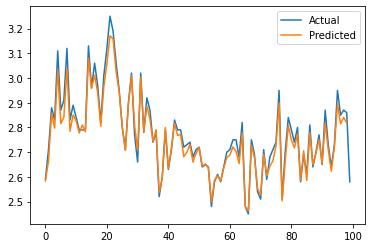

MSE of AR: 0.0009361363509068216


In [6]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(ar_predictions, label="Predicted")
plt.legend()
plt.show()
print(f"MSE of AR: {ar_mse}")

#### ARIMA

In [7]:
def ArimaModel(train_data, test_data, arima_order: tuple, steps):
    """
    Arima using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = ARIMA(history, order=arima_order).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    mse = mean_squared_error(test_data[:steps-1],predictions[1:])
    
    return predictions[1:], mse

In [12]:
arima_predictions, arima_mse = ArimaModel(train.swh.values, test.swh.values, (2,0,1), 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.92s/it]


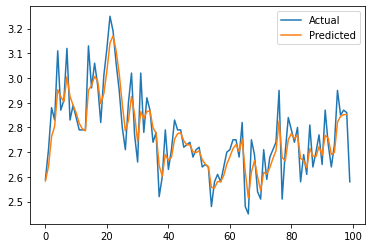

MSE of ARIMA: 0.00451660639328086


In [13]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(arima_predictions, label="Predicted")
plt.legend()
plt.show()
print(f"MSE of ARIMA: {arima_mse}")

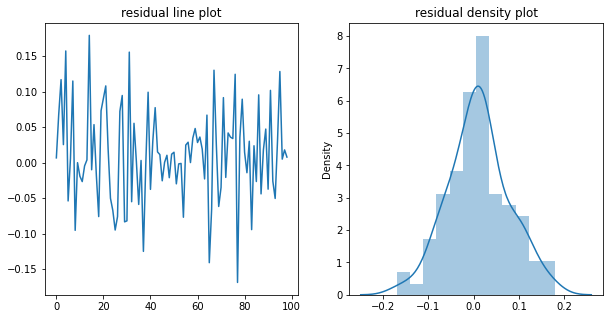

,0
count,99.000000
mean,0.011058
std,0.066627
min,-0.168862
25%,-0.026620
50%,0.010418
75%,0.044634
max,0.179495


In [14]:
residuals = pd.DataFrame(test.swh.values[:99] - arima_predictions)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(residuals)
ax2.set_title("residual density plot")
plt.show()
residuals.describe()

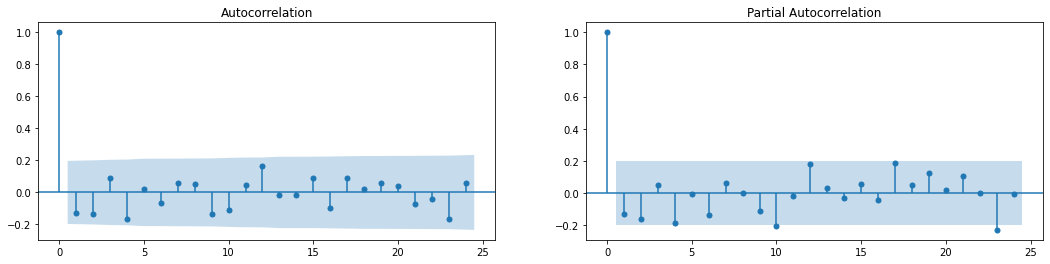

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(residuals, lags=24, ax=ax1)
ax2 = plot_pacf(residuals, lags=24, ax=ax2)

Search for the best fit parameter

In [17]:
def GridArimaModel(train_data, test_data, p_values: list, d_values: list, q_values: list, steps):
    """
    Best fit Arima using walk forward validation
    """
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    _, mse = ArimaModel(train_data, test_data, (p,d,q), steps)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue

    predictions, mse = ArimaModel(train_data, test_data, best_cfg, steps)

    return predictions, best_cfg, best_score

In [22]:
best_prediction, best_cfg, best_score = GridArimaModel(train.swh.values, test.swh.values,list(range(1,3)), [0], [1], 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/it]


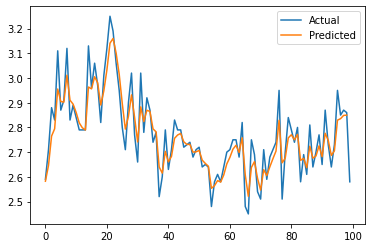

Best parameter of order: (1, 0, 1)
MSE of ARIMA: 0.0038912259457331453


In [23]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(best_prediction, label="Predicted")
plt.legend()
plt.show()
print(f"Best parameter of order: {best_cfg}")
print(f"MSE of ARIMA: {best_score}")

----

In [ ]:
# train_swh = train.swh.values
# train_rows = train_swh.shape[0] - 6
# train_df = np.zeros((train_rows+1, 6))
# for idx, start in enumerate(range(0, len(train_swh) - 5)):
#     row = train_swh[start:start+6]
#     train_df[idx, :] = row

In [ ]:
# train_df.shape

In [ ]:
# test_swh = test.swh.values
# test_rows = test_swh.shape[0] - 6
# test_df = np.zeros((test_rows+1,6))
# for idx, start in enumerate(range(0, len(test_swh) - 5)):
#     row = test_swh[start:start+6]
#     test_df[idx, :] = row

In [ ]:
# test_df.shape

In [ ]:
# X = train_df[:, :5]
# y = train_df[:, 5]

In [ ]:
# # time series train test split

# tscv = TimeSeriesSplit(n_splits=3)

# for train_index, test_index in tscv.split(train_df):

#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]